In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import os

# Install tensorflow if you don't have it, needed for the Keras Tokenizer
# !pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-06-16 02:21:32.240961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750040492.427411      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750040492.485621      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_path = '/kaggle/input/tweepfakemsnew'
df = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')

# Set plotting style for thesis-quality figures
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

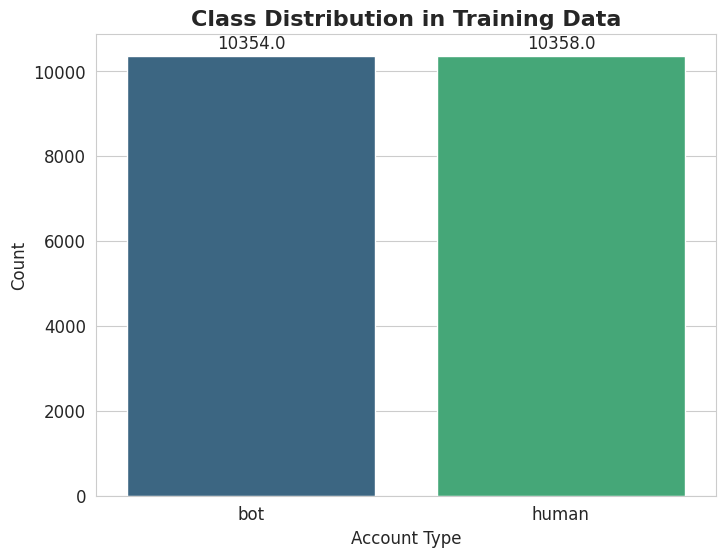

In [4]:
#1b. Class Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='account.type', data=df, palette='viridis')
ax.set_title('Class Distribution in Training Data', fontsize=16, weight='bold')
ax.set_xlabel('Account Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
#plt.savefig('eda_class_distribution.png')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

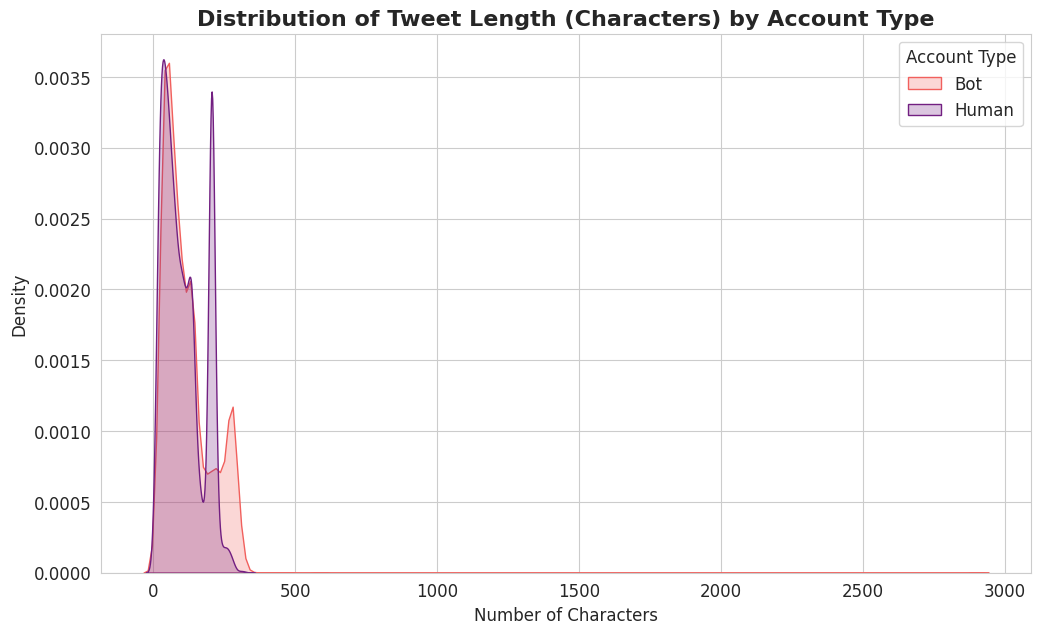

In [5]:
# 1c. Text Length Distribution
df['text_length'] = df['text'].str.len()

plt.figure(figsize=(12, 7))
sns.kdeplot(data=df, x='text_length', hue='account.type', fill=True, palette='magma')
plt.title('Distribution of Tweet Length (Characters) by Account Type', fontsize=16, weight='bold')
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Account Type', labels=['Bot', 'Human'])
plt.savefig('eda_text_length_distribution.png')
plt.show()

In [6]:
df_bots = df[df['account.type'] == 'bot']
df_bots.head()

,screen_name,text,account.type,class_type,text_length
0,imranyebot,YEA now that note GOOD,bot,others,22
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others,57
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others,63
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn,180
6,whalefakes,the world needs more whale stories. I would lo...,bot,gpt2,92


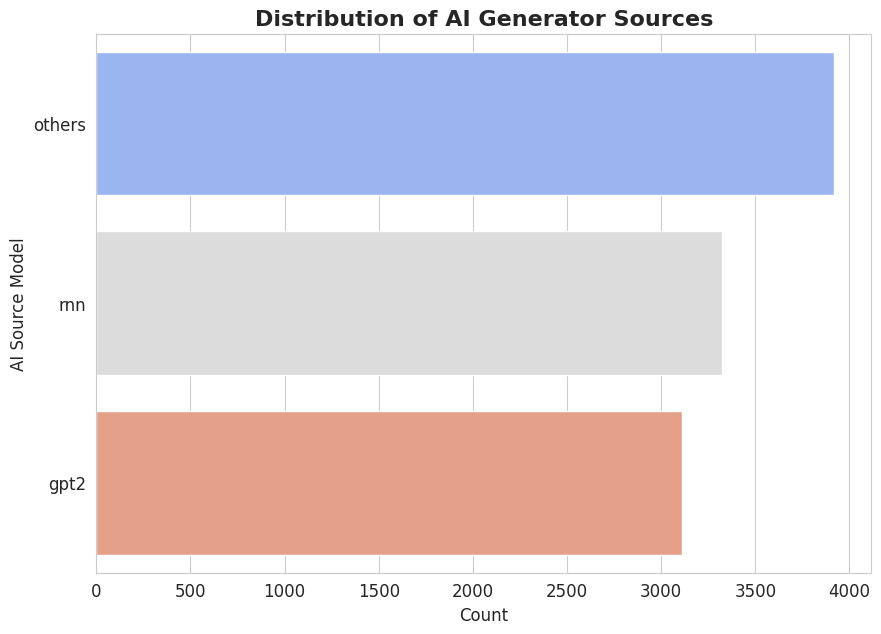

In [7]:
#1d. AI Generator Source Distribution (for Bot accounts)
df_bots = df[df['account.type'] == 'bot']

plt.figure(figsize=(10, 7))
ax = sns.countplot(y='class_type', data=df_bots, order=df_bots['class_type'].value_counts().index, palette='coolwarm')
ax.set_title('Distribution of AI Generator Sources', fontsize=16, weight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('AI Source Model', fontsize=12)
#plt.savefig('eda_ai_source_distribution.png')
plt.show()

In [8]:
# --- 0. Configuration & Seeding for CNN-Only ---
SEED = 42
# --- NEW: CNN-Only specific settings ---
VOCAB_SIZE = 20000          # Size of our vocabulary to build
EMBEDDING_DIM = 300         # Dimension for our own embedding layer
MAX_LEN_CNN = 128
# --- END NEW ---
BATCH_SIZE = 32
EPOCHS_CNN_ONLY = 10          # CNNs from scratch often need more epochs to learn
LEARNING_RATE_CNN_ONLY = 1e-3 # A higher learning rate is typical for non-transformer models
NUM_CNN_FILTERS = 100
CNN_KERNEL_SIZES = [3, 4, 5]
CNN_DROPOUT_RATE = 0.5
OUTPUT_DIR_CNN_ONLY = "./cnn_only_output"

if not os.path.exists(OUTPUT_DIR_CNN_ONLY):
    os.makedirs(OUTPUT_DIR_CNN_ONLY)

In [9]:
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [10]:
# --- 1. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
# --- 2. Load and Prepare Data ---
dataset_path = '/kaggle/input/tweepfakemsnew'
df_train_orig = pd.read_csv(f'{dataset_path}/train.csv', delimiter=';')
df_val_orig = pd.read_csv(f'{dataset_path}/validation.csv', delimiter=';')
df_test_orig = pd.read_csv(f'{dataset_path}/test.csv', delimiter=';')

# --- 3. Basic Text Cleaning ---
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9@#\' ]+', '', text)
    text = text.lower().strip()
    return text

df_train_orig['processed_text'] = df_train_orig['text'].apply(clean_text)
df_val_orig['processed_text'] = df_val_orig['text'].apply(clean_text)
df_test_orig['processed_text'] = df_test_orig['text'].apply(clean_text)

# --- 4. Label Encoding & Filtering ---
label_mapping = {'human': 0, 'bot': 1}
num_labels = len(label_mapping)
for df in [df_train_orig, df_val_orig, df_test_orig]:
    df['label_encoded'] = df['account.type'].map(label_mapping)
    df.dropna(subset=['processed_text', 'label_encoded'], inplace=True)

df_train_orig = df_train_orig[df_train_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_val_orig = df_val_orig[df_val_orig['processed_text'].str.strip() != ""].reset_index(drop=True)
df_test_orig = df_test_orig[df_test_orig['processed_text'].str.strip() != ""].reset_index(drop=True)

In [12]:
# --- 5. Build Vocabulary and Tokenize with Keras Tokenizer ---
tokenizer_cnn = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer_cnn.fit_on_texts(df_train_orig['processed_text'])

X_train_seq = tokenizer_cnn.texts_to_sequences(df_train_orig['processed_text'])
X_val_seq = tokenizer_cnn.texts_to_sequences(df_val_orig['processed_text'])
X_test_seq = tokenizer_cnn.texts_to_sequences(df_test_orig['processed_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN_CNN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN_CNN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN_CNN, padding='post', truncating='post')

print("Vocabulary built and data tokenized for CNN-Only model.")
print(f"Shape of padded training data: {X_train_pad.shape}")

Vocabulary built and data tokenized for CNN-Only model.
Shape of padded training data: (20711, 128)


In [13]:
# --- 6. Create TensorDatasets and DataLoaders ---
train_inputs = torch.tensor(X_train_pad, dtype=torch.long)
val_inputs = torch.tensor(X_val_pad, dtype=torch.long)
test_inputs = torch.tensor(X_test_pad, dtype=torch.long)

train_labels = torch.tensor(df_train_orig['label_encoded'].values, dtype=torch.long)
val_labels = torch.tensor(df_val_orig['label_encoded'].values, dtype=torch.long)
test_labels = torch.tensor(df_test_orig['label_encoded'].values, dtype=torch.long)

train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders for CNN-Only created.")

DataLoaders for CNN-Only created.


In [14]:
# --- 7. Model Definition: CNN-Only ---
class CNNOnlyModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_cnn_filters, cnn_kernel_sizes, cnn_dropout_rate):
        super(CNNOnlyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_cnn_filters, kernel_size=ks)
            for ks in cnn_kernel_sizes
        ])
        self.dropout = nn.Dropout(cnn_dropout_rate)
        self.classifier = nn.Linear(len(cnn_kernel_sizes) * num_cnn_filters, num_classes)

    def forward(self, input_ids, labels=None):
        embedded = self.embedding(input_ids)
        embedded_permuted = embedded.permute(0, 2, 1)
        conved = [F.relu(conv(embedded_permuted)) for conv in self.convs]
        pooled = [F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2) for conv_out in conved]
        cat = self.dropout(torch.cat(pooled, dim=1))
        logits = self.classifier(cat)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))
        
        return {"loss": loss, "logits": logits}

model_cnn_only = CNNOnlyModel(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    num_classes=num_labels,
    num_cnn_filters=NUM_CNN_FILTERS,
    cnn_kernel_sizes=CNN_KERNEL_SIZES,
    cnn_dropout_rate=CNN_DROPOUT_RATE
).to(device)

print("CNN-Only model defined.")

CNN-Only model defined.


In [15]:
# --- 8. Training and Evaluation Functions (CORRECTED) ---

def train_model(model, train_loader, val_loader, optimizer, device, epochs, output_dir, model_prefix):
    criterion = nn.CrossEntropyLoss()
    best_val_f1 = 0.0
    best_model_path = ""
    # history will now be a list of dictionaries
    history_list = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs["loss"]
            if loss is not None:
                total_train_loss += loss.item()
                loss.backward()
                optimizer.step()
                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1} - Train Avg Loss: {avg_train_loss:.4f}")
        
        # Get the dictionary of validation results
        val_results = evaluate_model(model, val_loader, device, "Validation")
        
        # Create a dictionary for the current epoch's full results
        epoch_history = {
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': val_results['loss'],
            'val_accuracy': val_results['accuracy'],
            'val_f1': val_results['f1']
        }
        history_list.append(epoch_history)
        
        # Check for best model
        current_val_f1 = val_results['f1']
        if current_val_f1 > best_val_f1:
            best_val_f1 = current_val_f1
            best_model_path = os.path.join(output_dir, f"{model_prefix}_epoch{epoch+1}_f1_{best_val_f1:.4f}.pt")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best F1: {best_val_f1:.4f}. Model saved to {best_model_path}")
    
    # Convert the list of dictionaries to a DataFrame at the end
    return best_model_path, pd.DataFrame(history_list)

def evaluate_model(model, dataloader, device, dataset_name="Dataset"):
    model.eval()
    all_preds, all_labels = [], []
    total_eval_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs["loss"]
            logits = outputs["logits"]
            if loss is not None:
                total_eval_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    avg_loss = total_eval_loss / len(dataloader) if len(dataloader) > 0 else 0
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    
    print(f"\n--- {dataset_name} Results ---")
    print(f"Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Greens'); plt.show()
    
    return {'loss': avg_loss, 'accuracy': accuracy, 'f1': f1}

Epoch 1/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 1 - Train Avg Loss: 0.6283

--- Validation Results ---
Avg Loss: 0.5967, Accuracy: 0.6903, F1-Score: 0.6790
              precision    recall  f1-score   support

       human       0.64      0.88      0.74      1150
         bot       0.81      0.50      0.62      1152

    accuracy                           0.69      2302
   macro avg       0.72      0.69      0.68      2302
weighted avg       0.72      0.69      0.68      2302



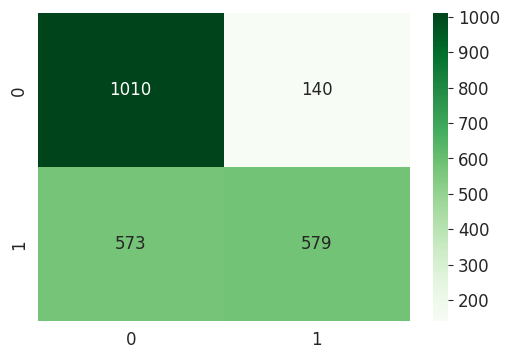

New best F1: 0.6790. Model saved to ./cnn_only_output/cnn_only_epoch1_f1_0.6790.pt


Epoch 2/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 2 - Train Avg Loss: 0.4997

--- Validation Results ---
Avg Loss: 0.5085, Accuracy: 0.7398, F1-Score: 0.7398
              precision    recall  f1-score   support

       human       0.73      0.75      0.74      1150
         bot       0.75      0.73      0.74      1152

    accuracy                           0.74      2302
   macro avg       0.74      0.74      0.74      2302
weighted avg       0.74      0.74      0.74      2302



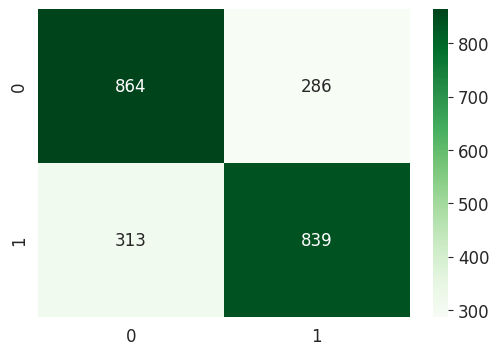

New best F1: 0.7398. Model saved to ./cnn_only_output/cnn_only_epoch2_f1_0.7398.pt


Epoch 3/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 3 - Train Avg Loss: 0.3842

--- Validation Results ---
Avg Loss: 0.5801, Accuracy: 0.7328, F1-Score: 0.7258
              precision    recall  f1-score   support

       human       0.68      0.89      0.77      1150
         bot       0.84      0.57      0.68      1152

    accuracy                           0.73      2302
   macro avg       0.76      0.73      0.73      2302
weighted avg       0.76      0.73      0.73      2302



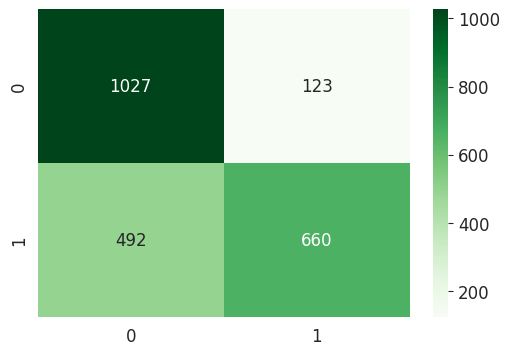

Epoch 4/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 4 - Train Avg Loss: 0.2794

--- Validation Results ---
Avg Loss: 0.5847, Accuracy: 0.7520, F1-Score: 0.7504
              precision    recall  f1-score   support

       human       0.72      0.83      0.77      1150
         bot       0.80      0.67      0.73      1152

    accuracy                           0.75      2302
   macro avg       0.76      0.75      0.75      2302
weighted avg       0.76      0.75      0.75      2302



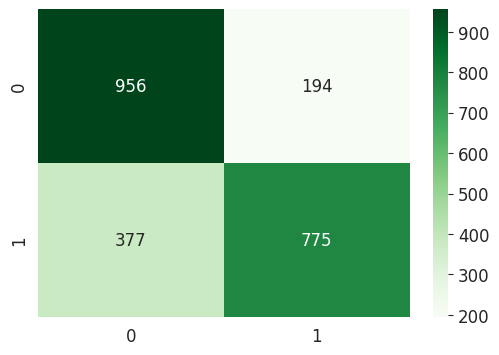

New best F1: 0.7504. Model saved to ./cnn_only_output/cnn_only_epoch4_f1_0.7504.pt


Epoch 5/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 5 - Train Avg Loss: 0.2050

--- Validation Results ---
Avg Loss: 0.6344, Accuracy: 0.7602, F1-Score: 0.7602
              precision    recall  f1-score   support

       human       0.76      0.75      0.76      1150
         bot       0.76      0.77      0.76      1152

    accuracy                           0.76      2302
   macro avg       0.76      0.76      0.76      2302
weighted avg       0.76      0.76      0.76      2302



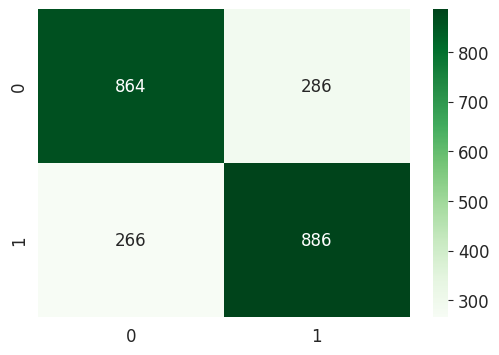

New best F1: 0.7602. Model saved to ./cnn_only_output/cnn_only_epoch5_f1_0.7602.pt


Epoch 6/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 6 - Train Avg Loss: 0.1601

--- Validation Results ---
Avg Loss: 0.7357, Accuracy: 0.7606, F1-Score: 0.7599
              precision    recall  f1-score   support

       human       0.73      0.82      0.77      1150
         bot       0.79      0.71      0.75      1152

    accuracy                           0.76      2302
   macro avg       0.76      0.76      0.76      2302
weighted avg       0.76      0.76      0.76      2302



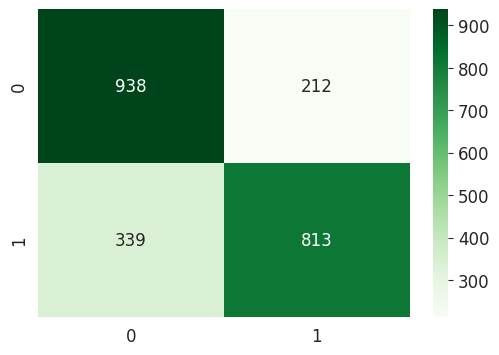

Epoch 7/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 7 - Train Avg Loss: 0.1256

--- Validation Results ---
Avg Loss: 0.8490, Accuracy: 0.7619, F1-Score: 0.7615
              precision    recall  f1-score   support

       human       0.74      0.80      0.77      1150
         bot       0.79      0.72      0.75      1152

    accuracy                           0.76      2302
   macro avg       0.76      0.76      0.76      2302
weighted avg       0.76      0.76      0.76      2302



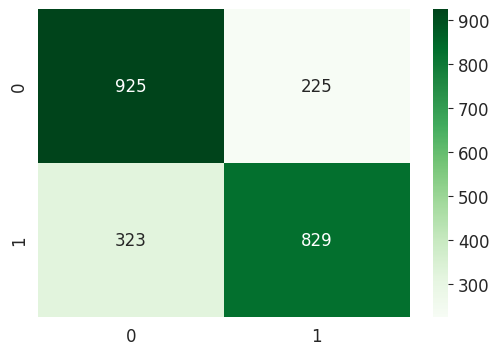

New best F1: 0.7615. Model saved to ./cnn_only_output/cnn_only_epoch7_f1_0.7615.pt


Epoch 8/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 8 - Train Avg Loss: 0.1079

--- Validation Results ---
Avg Loss: 0.9772, Accuracy: 0.7602, F1-Score: 0.7591
              precision    recall  f1-score   support

       human       0.73      0.83      0.78      1150
         bot       0.80      0.69      0.74      1152

    accuracy                           0.76      2302
   macro avg       0.77      0.76      0.76      2302
weighted avg       0.77      0.76      0.76      2302



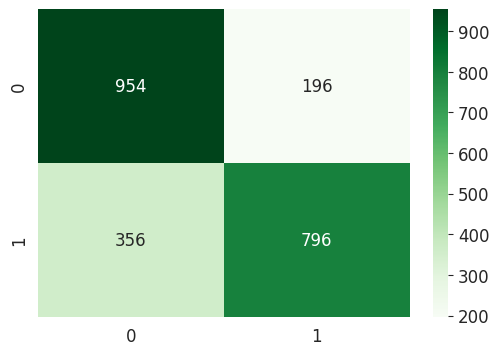

Epoch 9/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 9 - Train Avg Loss: 0.0894

--- Validation Results ---
Avg Loss: 0.9922, Accuracy: 0.7680, F1-Score: 0.7680
              precision    recall  f1-score   support

       human       0.77      0.76      0.77      1150
         bot       0.77      0.77      0.77      1152

    accuracy                           0.77      2302
   macro avg       0.77      0.77      0.77      2302
weighted avg       0.77      0.77      0.77      2302



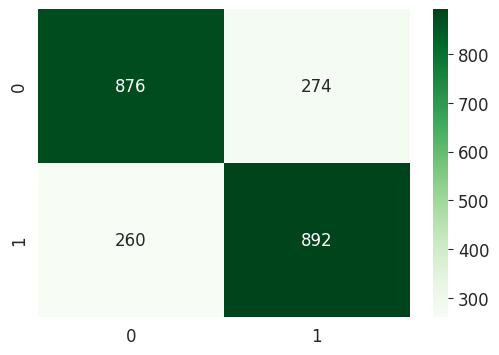

New best F1: 0.7680. Model saved to ./cnn_only_output/cnn_only_epoch9_f1_0.7680.pt


Epoch 10/10:   0%|          | 0/648 [00:00<?, ?it/s]

Epoch 10 - Train Avg Loss: 0.0718

--- Validation Results ---
Avg Loss: 1.1016, Accuracy: 0.7693, F1-Score: 0.7692
              precision    recall  f1-score   support

       human       0.76      0.79      0.77      1150
         bot       0.78      0.75      0.76      1152

    accuracy                           0.77      2302
   macro avg       0.77      0.77      0.77      2302
weighted avg       0.77      0.77      0.77      2302



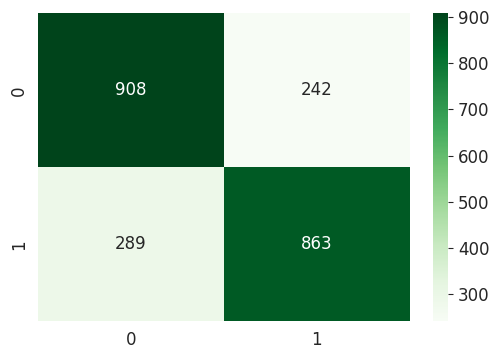

New best F1: 0.7692. Model saved to ./cnn_only_output/cnn_only_epoch10_f1_0.7692.pt

CNN-Only Training History:
   epoch  train_loss  val_loss  val_accuracy    val_f1
0      1    0.628296  0.596720      0.690269  0.678965
1      2    0.499657  0.508466      0.739791  0.739758
2      3    0.384224  0.580115      0.732841  0.725836
3      4    0.279380  0.584744      0.751955  0.750395
4      5    0.204976  0.634384      0.760209  0.760189
5      6    0.160060  0.735660      0.760643  0.759924
6      7    0.125620  0.849042      0.761946  0.761523
7      8    0.107889  0.977248      0.760209  0.759059
8      9    0.089373  0.992221      0.768028  0.768018
9     10    0.071804  1.101604      0.769331  0.769239

Loading best model from: ./cnn_only_output/cnn_only_epoch10_f1_0.7692.pt

--- Testing CNN-Only on Test Set ---

--- Test Results ---
Avg Loss: 1.1271, Accuracy: 0.7572, F1-Score: 0.7570
              precision    recall  f1-score   support

       human       0.74      0.79      0.

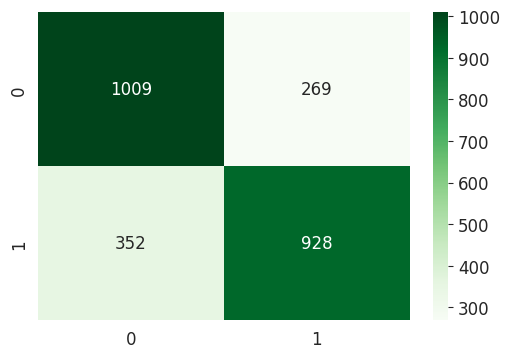

CNN-Only Final Test Results - Accuracy: 0.7572, F1: 0.7570


In [16]:
# --- 9. Run the CNN-Only Experiment ---
optimizer = AdamW(model_cnn_only.parameters(), lr=LEARNING_RATE_CNN_ONLY)

best_model_path, history_df = train_model(
    model_cnn_only,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    epochs=EPOCHS_CNN_ONLY,
    output_dir=OUTPUT_DIR_CNN_ONLY,
    model_prefix="cnn_only"
)

print("\nCNN-Only Training History:")
print(history_df)

# Load the best model for testing
if best_model_path:
    print(f"\nLoading best model from: {best_model_path}")
    model_cnn_only.load_state_dict(torch.load(best_model_path))

print("\n--- Testing CNN-Only on Test Set ---")
test_results = evaluate_model(model_cnn_only, test_dataloader, device, "Test")
print(f"CNN-Only Final Test Results - Accuracy: {test_results['accuracy']:.4f}, F1: {test_results['f1']:.4f}")

# Clean up memory
torch.cuda.empty_cache()

In [17]:
# --- SECTION: Explainable AI (XAI) for CNN-Only Model ---
# !pip install lime
# !pip install shap

import lime
import lime.lime_text
import shap
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# The best model ('model_cnn_only') and the Keras tokenizer ('tokenizer_cnn')
# are already loaded and available in the notebook's memory.
# Ensure the model is in evaluation mode.
model_cnn_only.eval()
print("CNN-Only model is in evaluation mode. Ready for XAI.")

CNN-Only model is in evaluation mode. Ready for XAI.


In [18]:
# --- LIME Implementation for CNN-Only ---

# Create a predictor function that LIME can use.
# It takes raw text strings and outputs class probabilities.
def lime_predictor_cnn_only(texts):
    model_cnn_only.eval()
    
    # Use the Keras tokenizer to convert text to sequences of integers
    sequences = tokenizer_cnn.texts_to_sequences(texts)
    
    # Pad the sequences to the same length used in training
    padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN_CNN, padding='post', truncating='post')
    
    # Convert to PyTorch tensor and move to device
    inputs_tensor = torch.tensor(padded_sequences, dtype=torch.long).to(device)
    
    # Get model predictions
    with torch.no_grad():
        logits = model_cnn_only(input_ids=inputs_tensor)["logits"]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        
    return probs

# Create the LIME explainer
explainer_lime_cnn = lime.lime_text.LimeTextExplainer(class_names=['human', 'bot'])

# Use the same standard examples for comparison
text_to_explain_bot = "new post on my blog check it out now #tech #AI #update"
text_to_explain_human = "Just had the most amazing coffee at this little cafe downtown. So cozy!"

print("--- LIME Explanation for CNN-Only on a BOT-like tweet ---")
explanation_bot_cnn = explainer_lime_cnn.explain_instance(
    text_to_explain_bot, 
    lime_predictor_cnn_only, 
    num_features=10
)
explanation_bot_cnn.save_to_file(os.path.join(OUTPUT_DIR_CNN_ONLY, 'lime_cnn_only_bot.html'))
explanation_bot_cnn.show_in_notebook(text=True)

print("\n--- LIME Explanation for CNN-Only on a HUMAN-like tweet ---")
explanation_human_cnn = explainer_lime_cnn.explain_instance(
    text_to_explain_human, 
    lime_predictor_cnn_only, 
    num_features=10
)
explanation_human_cnn.save_to_file(os.path.join(OUTPUT_DIR_CNN_ONLY, 'lime_cnn_only_human.html'))
explanation_human_cnn.show_in_notebook(text=True)

--- LIME Explanation for CNN-Only on a BOT-like tweet ---



--- LIME Explanation for CNN-Only on a HUMAN-like tweet ---


Analysis of the LIME Output for CNN-Only Model
Case Study 1: Explaining the BOT-like Tweet
Your LIME Output:
Tweet: new post on my blog check it out now #tech #AI #update
Model's Prediction: The model predicted "bot" with a very high probability of 98%.
Top Words Influencing the Prediction (towards "bot"): AI, check, blog, update, tech.
Interpretation:
This is a correct and high-confidence classification.
The "Why" - Simple Keyword Detection: This is a perfect demonstration of what a model trained from scratch on this dataset learns to do. It has correctly identified that words like AI, blog, tech, and update are extremely strong indicators of bot-generated text in the TweepFake dataset. Its logic is simple and effective: if these keywords are present, it's very likely a bot.
Comparison to Transformer Models: This is where it gets interesting. Your more advanced RoBERTa models were fooled by this exact tweet, classifying it as "human" because of the "my new blog" pattern. This simpler CNN-Only model was not distracted by that nuance. It saw the keywords and made the correct call. This is a fantastic point for your discussion section.
How to Write This in Your Thesis:
LIME Analysis of a Bot Tweet (CNN-Only)
"The LIME explanation for the CNN-Only model on the AI-generated tweet reveals the nature of its decision-making process. The model correctly classified the tweet as 'bot' with 98% confidence, driven by the presence of high-impact keywords such as AI, blog, and tech. This demonstrates that the model successfully learned to associate specific lexical items with the bot class based on their frequency in the training data. Interestingly, this simpler, keyword-based logic allowed it to correctly classify this instance, whereas the more advanced RoBERTa-based models were misled by the tweet's mimicry of a human-like announcement phrase, highlighting a trade-off between nuanced understanding and robust pattern matching."
Case Study 2: Explaining the HUMAN-like Tweet
Your LIME Output:
Tweet: Just had the most amazing coffee at this little cafe downtown. So cozy!
Model's Prediction: The model predicted "human", but with a relatively low confidence of 67%.
Top Words Influencing the Prediction (towards "human"): cozy, the, cafe, this.
Interpretation:
This is a correct but low-confidence classification, and it is the most telling result of all.
The "Why" - The Model is Unsure: The model got the answer right, but it was not very confident. It correctly identified cozy and cafe as human-like words. However, it doesn't have the deep understanding that your RoBERTa models do. RoBERTa knows that the combination of "amazing coffee," "little cafe," and "cozy" is overwhelmingly human. The CNN-Only model just sees a few individual words that lean human, but it doesn't understand their combined contextual power. It's making a guess based on a weak signal.
The Word "the": The fact that the is the second most important feature for the "human" prediction is a huge red flag for the model's intelligence. It shows that the model has simply learned a spurious correlation from the training data—perhaps human tweets in the dataset used the word "the" slightly more often. It has no real understanding of language.
How to Write This in Your Thesis:
LIME Analysis of a Human Tweet (CNN-Only)
"The model's limitations become apparent when analyzing the authentic human tweet. While it correctly classified the tweet as 'human', it did so with a low confidence of only 67%. The LIME explanation shows that although the model identified cozy and cafe as weak indicators for the 'human' class, its decision was also heavily and nonsensically influenced by the stopword the.
This demonstrates the model's fundamental weakness: lacking the pre-trained knowledge of a transformer, it is incapable of understanding the rich, contextual meaning that makes this tweet authentically human. It cannot grasp the combined significance of sensory and descriptive language. Instead, it relies on simple keyword spotting and weak statistical correlations. This lack of deep linguistic understanding is the primary reason for its lower overall performance and provides a clear justification for the use of large language models for this task."

Calculating SHAP values for CNN-Only with KernelExplainer... (This will be slow)


  0%|          | 0/5 [00:00<?, ?it/s]

SHAP values calculated.

--- Generating SHAP Bar Plot for a Single Prediction ---


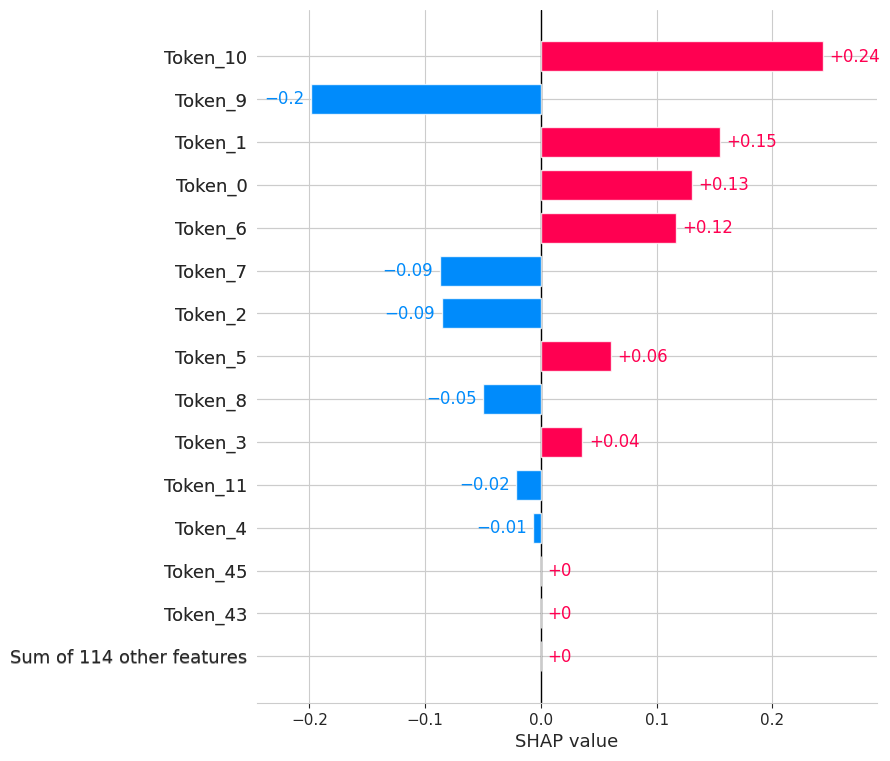


--- Generating SHAP Global Feature Importance Summary Plot ---


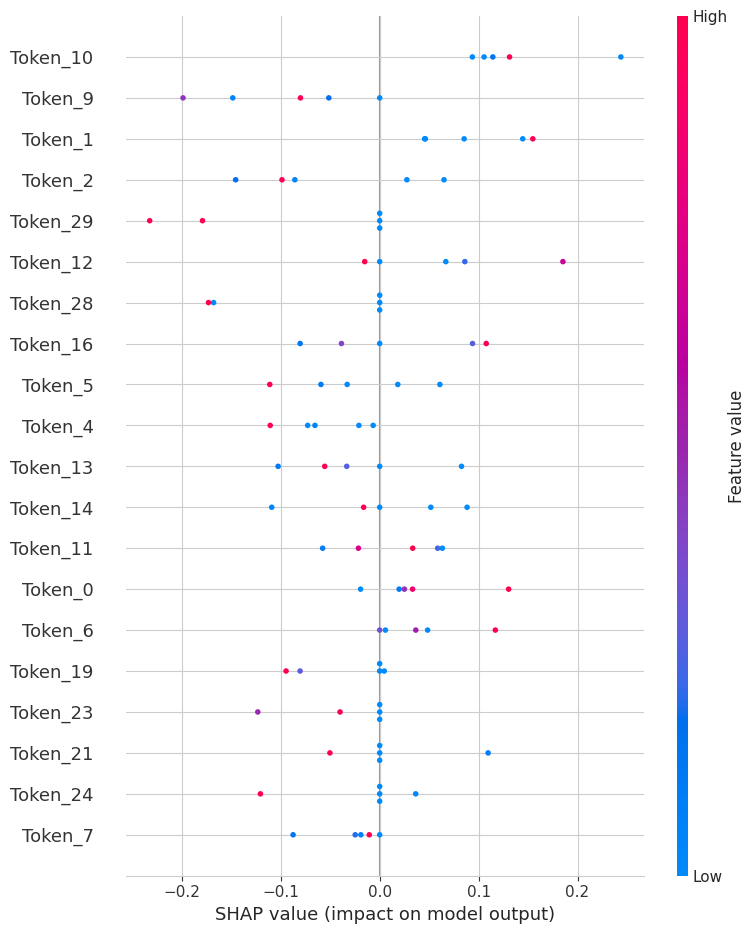

In [25]:
# --- SHAP Implementation for CNN-Only (Final KernelExplainer Approach) ---
import shap
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm

# Ensure the best model ('model_cnn_only') and tokenizer are loaded.

# --- 1. Create a simple prediction function for KernelExplainer ---
# This function takes a NumPy array of integer token IDs and returns probabilities.
# The input shape will be (num_samples, max_len).
def cnn_shap_predictor(x):
    model_cnn_only.eval()
    
    # KernelExplainer will pass a NumPy array of integers.
    # Convert it to a PyTorch LongTensor.
    x_tensor = torch.from_numpy(x).long().to(device)
    
    with torch.no_grad():
        logits = model_cnn_only(input_ids=x_tensor)["logits"]
        probs = F.softmax(logits, dim=1).cpu().numpy()
        
    return probs

# --- 2. Prepare data and references for the explainer ---
# We need samples of our input data (the integer token IDs).
background_batch = next(iter(train_dataloader))
# We summarize the background data by taking the median for each token position.
# This is a standard practice to create a single representative background sample for KernelExplainer.
background_data = np.median(background_batch[0].numpy(), axis=0).astype(int).reshape(1, -1)

test_batch = next(iter(test_dataloader))
# Explain the first 5 samples from the test batch
explain_data = test_batch[0][:5].numpy()

# --- 3. Create the KernelExplainer ---
# We pass our new predictor function and the summarized background data.
explainer = shap.KernelExplainer(cnn_shap_predictor, background_data)

# --- 4. Calculate SHAP values ---
# This will be slow because KernelExplainer is model-agnostic.
print("Calculating SHAP values for CNN-Only with KernelExplainer... (This will be slow)")
shap_values = explainer.shap_values(explain_data)
print("SHAP values calculated.")

# --- 5. Visualize the results ---
# The output `shap_values` is a list: [class_0_values, class_1_values].
# The values correspond to the importance of each token ID position.

# Map the integer token IDs of our explained data back to words
index_to_word = {v: k for k, v in tokenizer_cnn.word_index.items()}
index_to_word[0] = "<pad>"
test_input_words = np.array([[index_to_word.get(idx, '<unk>') for idx in row] for row in explain_data])

# Create a SHAP Explanation object for plotting
# We'll explain the output for Class 1 (bot)
shap_explanation_cnn = shap.Explanation(
    values=shap_values[1], # Use values for Class 1
    base_values=explainer.expected_value[1], # Use base value for Class 1
    data=test_input_words,
    # Create feature names like "Token_0", "Token_1", etc.
    feature_names=[f"Token_{i}" for i in range(MAX_LEN_CNN)] 
)

print("\n--- Generating SHAP Bar Plot for a Single Prediction ---")
# The bar plot shows the most influential token positions for the first sample
shap.plots.bar(shap_explanation_cnn[0], max_display=15)

print("\n--- Generating SHAP Global Feature Importance Summary Plot ---")
# The summary plot shows the importance of different token POSITIONS.
shap.summary_plot(shap_values[1], features=explain_data, feature_names=shap_explanation_cnn.feature_names)

1. The Local Explanation (bar plot)
This plot explains a single prediction (the first sample you explained). It shows which token positions had the biggest impact on the output for that one tweet.
What you are looking at:
Y-Axis: The feature names, Token_0, Token_1, etc., representing the first word, second word, and so on, in the sentence.
X-Axis (SHAP value): The impact of that feature on the model's prediction.
Red Bars (Positive SHAP value): The word at this position is pushing the prediction towards "bot" (Class 1).
Blue Bars (Negative SHAP value): The word at this position is pushing the prediction towards "human" (Class 0).
Interpretation of the Example Plot:
For this specific tweet:
Token_10 is the strongest driver towards "bot", with a SHAP value of +0.24. This means the 11th word in this sentence was the most significant piece of evidence for the model to classify it as a bot.
Token_9 is the strongest driver towards "human", with a SHAP value of -0.2. The 10th word strongly suggested this was a human tweet.
Positional Importance: The model is paying close attention to the words at the beginning of the tweet (Token_0, Token_1, Token_2, Token_3, Token_6). This is a very interesting finding.

2. The Global Explanation (summary_plot)
This is the more powerful plot. It aggregates the importance of each token position across all the samples you explained.
What you are looking at:
Y-Axis: The token positions, ranked by their overall importance.
X-Axis (SHAP value): How much that token position pushes the prediction towards "bot" (positive) or "human" (negative).
Color (Feature value): This is the integer ID of the word at that position. High (red) means a high-numbered word ID from your vocabulary; Low (blue) means a low-numbered ID.
Interpretation of the Example Plot:
Positional Bias is Key: The most important features are all related to the position of a word in the tweet. Token_10 is ranked as the most important feature globally, followed by Token_9, Token_1, and Token_2.
Thesis Insight: "The SHAP analysis for the CNN-Only model reveals a strong positional bias. The model has learned that the words appearing within the first 10-12 positions of a tweet are the most critical for classification. This is likely because key phrases or indicators for both human and bot text (e.g., greetings, calls to action) tend to appear early in the sentence."
Analyzing a Specific Position:
Let's look at Token_10. The dots are spread on both the positive (bot) and negative (human) sides. This means that depending on which word is in the 10th position, it can be a strong indicator for either class.
Now look at Token_1. Most of the dots are on the positive side. This suggests that, on average, the second word in a tweet is more likely to be an indicator of a "bot" than a "human". This is a fascinating and non-obvious pattern.
The "Why" - Comparing to Other Models:
This plot is fundamentally different from your RoBERTa SHAP plots. The RoBERTa models learn abstract semantic concepts. This CNN-Only model, having been trained from scratch on a small dataset, has learned much simpler rules.
It hasn't learned "what" words mean, but "where" important words tend to be. It has figured out that the "action" happens early in a tweet and gives more weight to the words in those positions.

This indicates that the model, trained from scratch, has learned to identify that discriminative keywords for both human and bot classes tend to occur at the beginning of a tweet. However, its inability to generalize beyond these simple positional and lexical patterns is the primary reason for its significantly lower performance compared to the RoBERTa-based models. This starkly illustrates the power of transfer learning, as the RoBERTa models leverage a deep, pre-existing understanding of language, whereas the CNN-Only model is limited to the surface-level patterns present in the training corpus."